In [3]:
from math import floor
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])


DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
actions = [UP, DOWN, LEFT, RIGHT]


class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.grid=np.array([[0 for _ in range(num_cols)] for _ in range(num_rows)])
        self.done = False
        self.steps = 0
        seed=None
        self.random_generator = np.random.RandomState(seed)
        self.max_steps=100
        self.done=False

    # this function useful for visuliaze grid
    def create_grid(self):
        for state in self.start_state:         # start state
          self.grid[state[0]][state[1]] = 1

        for state in self.goal_states:         # goal state
          self.grid[state[0]][state[1]] = 2

        for state in self.obs_states:
          self.grid[state[0]][state[1]] = 3    # obstacles state

        for state in self.bad_states:
          self.grid[state[0]][state[1]] = 4    # bad state

        for state in self.restart_states:
          self.grid[state[0]][state[1]] = 5    # restart state


    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq=(row_col_to_seq(self.start_state, self.num_cols))
        self.goal_states_seq=(row_col_to_seq(self.goal_states, self.num_cols))

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state




    '''
    reset: resets the environment by randomly choosing a start and goal state
    '''
    def reset(self):

        self.done = False
        self.steps = 0


        return int(self.start_state_seq)

    def is_in_grid(self, coord_x, coord_y):
        if coord_x < 0 or coord_y<0:
            return False
        if coord_x >= self.num_rows or coord_y >= self.num_cols:
            return False

        return True



    def step(self,state,action):

        self.steps += 1
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if(next_next in self.goal_states_seq or self.steps == 100):
            self.done = True
          return next_next, self.R[next_next], self.done
        else:
          if(next_state in self.goal_states_seq or self.steps == 100):
            self.done = True
          return next_state, self.R[next_state], self.done



    def render(self,state_,render_agent = False, ax = None):
        grid = self.grid.copy()
        for start in self.start_state:
            grid[start[0], start[1]] = 1
        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 2
        # # Mark obstacles (if any)
        if self.obs_states is not None:
            for obs in self.obs_states:
                grid[obs[0], obs[1]] = 3

        # # Mark bad states (if any)
        if self.bad_states is not None:
            for bad in self.bad_states:
                grid[bad[0], bad[1]] = 4

        # # Mark restart state(s)
        if self.restart_states is not None:
            for restart in self.restart_states:
                grid[restart[0], restart[1]] = 5
        if render_agent:
             grid[state_[0][0], state_[0][1]] = 6

        plt.clf()
        if not render_agent:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23'])
        else:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00','#000000'])
        if ax is None:
            fig, ax = plt.subplots()



        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)





class GridWorldWindyEnv(GridWorld):
    def __init__(self, grid_file, start_states = [(0,0)], goal_states = [(10,10)], goal_reward = 10, max_steps = 100,
                    action_fail_prob = 0.0, seed = None, windy_probab = 0.7):
        super(GridWorldWindyEnv, self).__init__(self, num_rows, num_cols, start_state, goal_states, wind = True,max_steps = 5000,action_fail_prob = 0.0,goal_reward = 10)
        self.windy_probab = windy_probab

    def step(self, action):
        ans = super().step(action)
        if not self.done and self.random_generator.rand() < self.windy_probab:
            ans1 = super().step(RIGHT)
            return ans1[0], ans[1]+ans1[1], ans1[2]
        return ans

# INITIAL STATE OF GRID

In [4]:
# specify world parameters
num_cols = 10
num_rows = 10

obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])
max_steps=5000
goal_reward = 10
wind=False

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = wind)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)

gw.create_grid()

env = gw.create_gridworld()



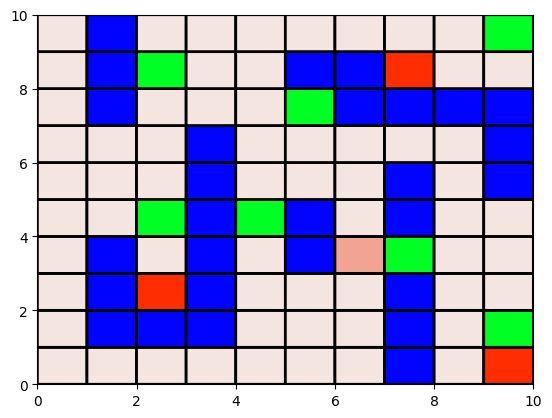

In [5]:
env.render(start_state,ax = plt)

# GENERALISED ENVIRONMENTS FOR EXPERIMENTS:

In [7]:
def generate_env(num_rows:int, num_cols:int, obstructions:np.ndarray, bad_states:np.ndarray, restart_states:np.ndarray, \
                 goal_states:np.ndarray, start_state:np.ndarray, step_reward:int, goal_reward:int, bad_state_reward:int, \
                 restart_state_reward:int, wind:bool = False, p_good_transition:float = 0.7) -> GridWorld:

    gw = GridWorld(num_rows=num_rows,num_cols=num_cols,start_state=start_state,goal_states=goal_states, wind=wind)
    gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
    gw.add_rewards(step_reward=step_reward,
                   goal_reward=goal_reward,
                   bad_state_reward=bad_state_reward,
                   restart_state_reward=restart_state_reward)
    gw.add_transition_probability(p_good_transition = p_good_transition, bias=0.5)
    gw.create_grid()
    env = gw.create_gridworld()
    return env


In [8]:
# specify world parameters
num_cols = 10
num_rows = 10
DOWN = 1
UP = 0
LEFT = 2
RIGHT = 3
actions = [UP,DOWN, LEFT, RIGHT]
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6],[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])
max_steps=5000
goal_reward = 10
p_good_transition = [1.0, 0.7]
# Specifies whether there is wind in the GridWorld environment
wind=[True, False]
# dictionary to store the specified 8 different GridWorld instances
environments = {}
# generate the specified 8 different GridWorld instances
for w in wind:
    for p in p_good_transition:
        if(w==True and p==0.7):
          continue
        for s in start_state:
            s=np.array([s])
            environments[f'wind={w}, p_good_transition={p}, start_state={s}'] = generate_env(num_rows=num_rows, num_cols=num_cols, obstructions=obstructions,
                                                                                bad_states=bad_states,restart_states=restart_states, goal_states=goal_states,
                                                                              start_state=s, step_reward=-1,goal_reward=+10, bad_state_reward=-6, restart_state_reward=-100, wind=w, p_good_transition=p)


In [9]:
(environments)

{'wind=True, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7df0>,
 'wind=True, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7160>,
 'wind=False, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7130>,
 'wind=False, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7190>,
 'wind=False, p_good_transition=0.7, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c41c0>,
 'wind=False, p_good_transition=0.7, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c52a0>}

In [10]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [11]:
env.P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

# POLICY

In [12]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy

def choose_action_epsilon(Q, state_, epsilon, rg=rg):

    if not Q[state_[0][0]][state_[0][1]].any():                 # TODO: eps greedy condition
        return rg.randint(0, len(Q[state_[0][0]][state_[0][1]]))         # TODO: return random action

    elif rg.rand() < epsilon:                # With probability epsilon, take a random action
        return rg.randint(0, len(Q[state_[0][0]][state_[0][1]]))                # Random action

    else:
        return np.argmax(Q[state_[0][0]][state_[0][1]])              # TODO: return best action



# Softmax

def choose_action_softmax(Q, state_,tau, rg=rg):
    action_values = Q[state_[0][0]][state_[0][1]]
    max_value = action_values.max()
    exp_values = [np.exp((v-max_value) / tau) for v in action_values]
    normalizer = np.sum(exp_values)
    prob = [v/normalizer for v in exp_values]
    action = np.random.choice(actions, p=prob)
    return action # TODO: return random action with selection probability

# SARSA :

In [13]:
from IPython.display import clear_output
from tqdm import tqdm

episodes=5000

print_freq = 100

def sarsa(env, Q, gamma = 0.1, plot_heat = False,choose_action= 0, epsilon= 0.1,tau = 1, alpha=0.1 , experiment_number=1):
    visits = np.zeros((10, 10))
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if choose_action == 0:
        method1 = "Epsilon-Greedy"
    else:
        method2 = "Softmax"

    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        state_ = seq_to_col_row(state, num_cols)
        visits[state_[0][0]][state_[0][1]] += 1
        if choose_action == 0:
          action = choose_action_epsilon(Q, state_, epsilon)
        else:
          action = choose_action_softmax(Q, state_, tau)
        done = False
        while not done:
            state_ = seq_to_col_row(state, num_cols)
            state_next, reward, done = env.step(state,action)
            state_next_ = seq_to_col_row(state_next, num_cols)


            if choose_action == 0:
              action_next = choose_action_epsilon(Q, state_next_, epsilon)
            else:
              action_next = choose_action_softmax(Q, state_next_, tau)

            visits[state_next_[0][0]][state_next_[0][1]] += 1

            # TODO: update equation

            Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:

            message = f"SARSA ( Experiment: {experiment_number} )\n"
            message += f" Wind: {env.wind}\n"
            message += f" probability: {env.p_good_trans}\n"
            message += f" Start State: {env.start_state}\n"
            if choose_action == 0:
                message += f" For Method : {method1}= {epsilon}\n"
            else:
                message += f" For Method : {method2}= {tau}\n"
            message += f" For Alpha := {alpha}\n"
            message += f" For Gamma := {gamma}\n"
            message += "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min())



    return Q, episode_rewards, steps_to_completion,visits

In [14]:
environments

{'wind=True, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7df0>,
 'wind=True, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7160>,
 'wind=False, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7130>,
 'wind=False, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7190>,
 'wind=False, p_good_transition=0.7, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c41c0>,
 'wind=False, p_good_transition=0.7, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c52a0>}

In [15]:
# This cell is for visulize hyperparameter values using graph

# import matplotlib.pyplot as plt
# import numpy as np

# # Define hyperparameters
# alpha_values = [0.01, 0.07, 0.1, 0.3]
# gamma_values = [0.5, 0.9, 0.99]
# tau_values = [0.001, 0.01,0.5]
# epsilon=0.1

# # Initialize variables to track maximum reward and corresponding hyperparameters
# max_reward = float('-200')
# best_alpha, best_gamma, best_tau = None, None, None

# # Create grid of plots
# fig, axes = plt.subplots(len(alpha_values), len(gamma_values), figsize=(15, 15), sharex=True, sharey=True)

# # Loop over hyperparameters and create plots
# for i, alpha in enumerate(alpha_values):
#     for j, gamma in enumerate(gamma_values):
#         # Dummy data for plotting (replace with your actual data)
#         rewards_all_experiments = []
#         steps_all_experiments = []
#         for tau in tau_values:
#             # Run Q-learning and store rewards and steps


#             f=0 # this is used for choosing grid environment from environments list values from 0 to 5: 0 means experiment 1

#             f2=0 # Choose action 0 for epsilon greedy and 1 for softmax
#             Q, rewards, steps ,visits= sarsa(list(environments.values())[f], Q, plot_heat=False, choose_action=f2, epsilon=epsilon, tau=tau, alpha=alpha, gamma=gamma, experiment_number=i+1)
#             rewards_all_experiments.append((rewards))
#             steps_all_experiments.append(steps)

#         # Plot rewards for all experiments
#         for k in range(len(tau_values)):
#             axes[i, j].plot(rewards_all_experiments[k], label=f'tau={tau_values[k]}')

#         # Set title
#         axes[i, j].set_title(f'Alpha={alpha}, Gamma={gamma}')

#         # Set labels
#         axes[i, j].set_xlabel('Episodes')
#         axes[i, j].set_ylabel('Rewards')

#         # Add legend
#         axes[i, j].legend()


# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()



In [30]:
environments

{'wind=True, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7df0>,
 'wind=True, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7160>,
 'wind=False, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7130>,
 'wind=False, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7190>,
 'wind=False, p_good_transition=0.7, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c41c0>,
 'wind=False, p_good_transition=0.7, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c52a0>}

In [ ]:
# Code for SARSA manual checking parameters and ploting heatmaps

# def plot_heatmap(data, mean_visits = 0, experiment_num = 0):

#         plt.title(f" Avg Number Of Visits for Experiment %d is :%.2f "%((experiment_num) , (mean_visits)))
#         plt.imshow(np.flipud(data), cmap = 'hot', interpolation='nearest')
#         plt.colorbar()
#         plt.show()
# def plot_Q(Q, message = "Q plot"):

#     plt.figure(figsize=(10,10))
#     plt.title(message)
#     plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
#     plt.colorbar()
#     def x_direct(a):
#         if a in [UP, DOWN]:
#             return 0
#         return 1 if a == RIGHT else -1
#     def y_direct(a):
#         if a in [RIGHT, LEFT]:
#             return 0
#         return 1 if a == DOWN else -1
#     policy = Q.argmax(-1)
#     policyx = np.vectorize(x_direct)(policy)
#     policyy = np.vectorize(y_direct)(policy)
#     idx = np.indices(policy.shape)
#     plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
#     plt.show()
# Q = np.zeros((10, 10, 4))



# #Note

# i=0 # choose environment from above list 0 based index

# j=1 # choose epsilon greedy or softmax : take j=0 for epsilon greedy and j=1 for softmax

# epsilon=0.1
# tau=0.1
# alpha=0.4
# gamma=0.99

# num_expts = 5
# reward_avgs, steps_avgs = np.zeros(5000), np.zeros(5000)
# Q1=np.zeros((10,10,4))
# V1=np.zeros((10,10))

# for i in range(num_expts):
#     print("Experiment: %d"%(i+1))
#     Q = np.zeros((10, 10, 4))
#     rg = np.random.RandomState(i)


#     Q, rewards, steps,visits = sarsa(list(environments.values())[i], Q, plot_heat=True, choose_action= j, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)
#     #addind for 5 run
#     reward_avgs = reward_avgs + rewards
#     steps_avgs = steps_avgs + steps
#     V1=V1+ visits
#     Q1= Q1+ Q
# # averaging over 5 runs
# reward_avgs = reward_avgs/num_expts
# steps_avgs = steps_avgs/num_expts
# V1=V1/5
# Q1=Q1/5



# plot_Q(Q1)
# plot_heatmap(visits,np.mean(V1),i+1)

# **Q - Learning** :

In [16]:
from IPython.display import clear_output
from tqdm import tqdm



print_freq = 100

def qlearning(env, Q, gamma = 0.1, plot_heat = False,choose_action= 0, epsilon= 0.1,tau = 1, alpha=0.1 , experiment_number=1):
    visits = np.zeros((10, 10))
    if choose_action == 0:
      method1 = "Epsilon-Greedy"
    else:
      method2 = "Softmax"
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    # if plot_heat:
    #     clear_output(wait=True)
    #     plot_Q(Q)

    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        state_ = seq_to_col_row(state, num_cols)
        visits[state_[0][0]][state_[0][1]] += 1
        if choose_action == 0:
          action = choose_action_epsilon(Q, state_, epsilon)
        else:
          action = choose_action_softmax(Q, state_, tau)
        done = False
        while not done:
            state_ = seq_to_col_row(state, num_cols)
            state_next, reward, done = env.step(state,action)
            state_next_ = seq_to_col_row(state_next, num_cols)


            if choose_action == 0:
              action_next = choose_action_epsilon(Q, state_next_, epsilon)
            else:
              action_next = choose_action_softmax(Q, state_next_, tau)

            visits[state_next_[0][0]][state_next_[0][1]] += 1

            # TODO: update equation

            Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])

            # Q-learning update equation

            max_next_q_value = np.max(Q[state_next_[0][0]][state_next_[0][1]])

            Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * max_next_q_value - Q[state_[0][0]][state_[0][1]][action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            message = f"Q-Learning ( Experiment: {experiment_number} )\n"
            message += f" Wind: {env.wind}\n"
            message += f" probability: {env.p_good_trans}\n"
            message += f" Start State: {env.start_state}\n"
            if choose_action == 0:
                message += f" For Method : {method1}= {epsilon}\n"
            else:
                message += f" For Method : {method2}= {tau}\n"
            message += f" For Alpha := {alpha}\n"
            message += f" For Gamma := {gamma}\n"
            message += "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min())




    return Q, episode_rewards, steps_to_completion,visits

In [189]:
Q, rewards, steps,visits = sarsa(env, Q, gamma = 0.9, plot_heat=True, choose_action= 1) # choose action 0 for e greedy and 1 for softmax

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-84-9fb1bda1c7fb>:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-143-f9c81fbddd80>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])
<ipython-input-143-f9c81fbddd80>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

# AVERAGE REWARDS AND STEPS PLOTS

In [17]:
environments

{'wind=True, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7df0>,
 'wind=True, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7160>,
 'wind=False, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7130>,
 'wind=False, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7190>,
 'wind=False, p_good_transition=0.7, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c41c0>,
 'wind=False, p_good_transition=0.7, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c52a0>}

In [18]:
#NOTE :

f1=0 # choose Experiment number use 0-based index from above environments list

f2=0 # for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters

epsilon=0.1

# Assigning best hyperparameter values based on graph provided in report

if(f1==0): # f1 is Experiment number 0 based index so f1 ranges from 0 to 5
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.4
  gamma=0.99
elif(f1==1):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
elif(f1==2):
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==3):
  choose_action=1
  f2=0
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==4):
  choose_action=1
  f2=0
  tau=0.4
  alpha=0.2
  gamma=0.99
elif(f1==5):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
else:
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
  epsilon=0.1


num_expts = 5 # for averaging over 5 runs
reward_avgs, steps_avgs = np.zeros(5000), np.zeros(5000)

for i in range(num_expts):
    print("Experiment: %d"%(f1+1))
    Q = np.zeros((10, 10, 4))
    rg = np.random.RandomState(i)

    if(f2==0): # f2 used for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters
      Q, rewards, steps,visits = sarsa(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)
    elif(f2==1):
      Q, rewards, steps,visits = qlearning(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)

    # adding rewards for 5 runs
    reward_avgs = reward_avgs + rewards
    steps_avgs = steps_avgs + steps

# averaging over 5 runs
reward_avgs = reward_avgs/num_expts
steps_avgs = steps_avgs/num_expts

Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-3-9fb1bda1c7fb>:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-16-5b498b0eb2e1>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])
<ipython-input-16-5b498b0eb2e1>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumP

Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 572.63it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 536.77it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 569.22it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 552.34it/s]


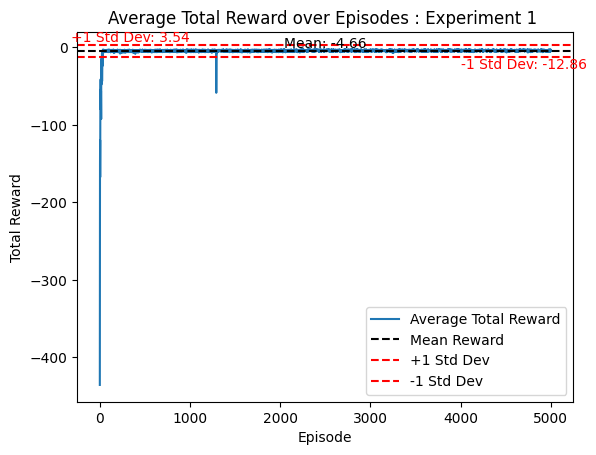

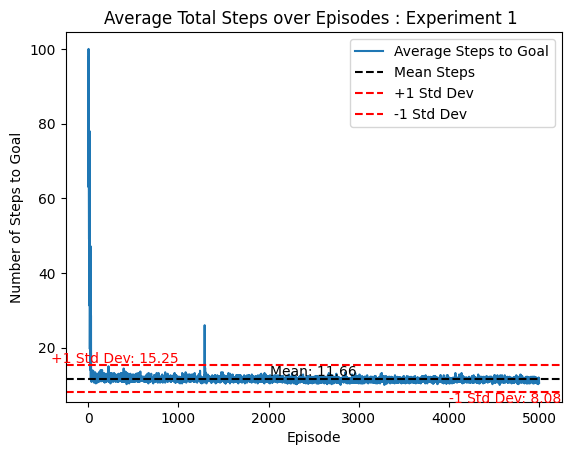

In [19]:
# Plotting average total reward
plt.figure()
plt.plot(reward_avgs, label='Average Total Reward')
plt.axhline(y=np.mean(reward_avgs), color='black', linestyle='--', label='Mean Reward')  # Highlight mean
plt.axhline(y=np.mean(reward_avgs) + np.std(reward_avgs), color='r', linestyle='--', label='+1 Std Dev')  # Highlight mean + 1 std dev
plt.axhline(y=np.mean(reward_avgs) - np.std(reward_avgs), color='r', linestyle='--', label='-1 Std Dev')  # Highlight mean - 1 std dev
plt.text(2500, np.mean(reward_avgs), f'Mean: {np.mean(reward_avgs):.2f}', color='black', ha='center', va='bottom')  # Add mean value as text
plt.text(1000, np.mean(reward_avgs) + np.std(reward_avgs), f'+1 Std Dev: {np.mean(reward_avgs) + np.std(reward_avgs):.2f}', color='r', ha='right', va='bottom')  # Add +1 std dev value as text
plt.text(4000, np.mean(reward_avgs) - np.std(reward_avgs), f'-1 Std Dev: {np.mean(reward_avgs) - np.std(reward_avgs):.2f}', color='r', ha='left', va='top')  # Add -1 std dev value as text
plt.xlabel('Episode')
plt.legend()
plt.ylabel('Total Reward')
plt.title('Average Total Reward over Episodes : Experiment %d '%(f1+1))  # Assign title to the graph
plt.show()

# Plotting average total steps
plt.figure()
plt.plot(steps_avgs, label='Average Steps to Goal')
plt.axhline(y=np.mean(steps_avgs), color='black', linestyle='--', label='Mean Steps')  # Highlight mean
plt.axhline(y=np.mean(steps_avgs) + np.std(steps_avgs), color='r', linestyle='--', label='+1 Std Dev')  # Highlight mean + 1 std dev
plt.axhline(y=np.mean(steps_avgs) - np.std(steps_avgs), color='r', linestyle='--', label='-1 Std Dev')  # Highlight mean - 1 std dev
plt.text(2500, np.mean(steps_avgs), f'Mean: {np.mean(steps_avgs):.2f}', color='black', ha='center', va='bottom')  # Add mean value as text
plt.text(1000, np.mean(steps_avgs) + np.std(steps_avgs), f'+1 Std Dev: {np.mean(steps_avgs) + np.std(steps_avgs):.2f}', color='r', ha='right', va='bottom')  # Add +1 std dev value as text
plt.text(4000, np.mean(steps_avgs) - np.std(steps_avgs), f'-1 Std Dev: {np.mean(steps_avgs) - np.std(steps_avgs):.2f}', color='r', ha='left', va='top')  # Add -1 std dev value as text
plt.xlabel('Episode')
plt.legend()
plt.ylabel('Number of Steps to Goal')
plt.title('Average Total Steps over Episodes : Experiment %d '%(f1+1))  # Assign title to the graph
plt.show()



# Heatmap Plots for Visits

In [20]:
def plot_heatmap(data, mean_visits = 0, experiment_num = 0):

        plt.title(f" Avg Number Of Visits for Experiment %d is :%.2f "%((experiment_num) , (mean_visits)))
        plt.imshow(np.flipud(data), cmap = 'hot', interpolation='nearest')
        plt.colorbar()
        plt.show()

Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-3-9fb1bda1c7fb>:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-16-5b498b0eb2e1>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])
<ipython-input-16-5b498b0eb2e1>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumP

Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.04it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 514.30it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 555.62it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 536.02it/s]


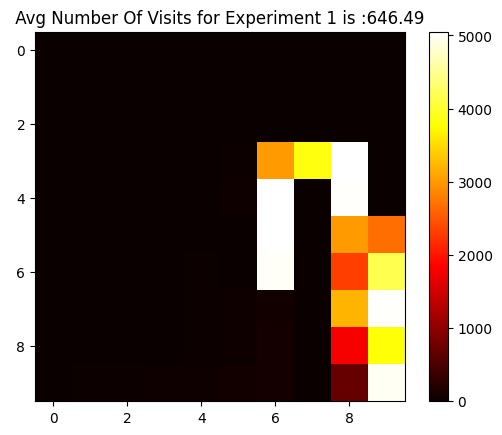

In [22]:
#Note:


f1=0 # choose Experiment number use 0-based index from above environments list

f2=0 # for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters

epsilon=0.1

# Assigning best hyperparameter values based on graph provided in report

if(f1==0): # f1 is Experiment number 0 based index so f1 ranges from 0 to 5
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.4
  gamma=0.99
elif(f1==1):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
elif(f1==2):
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==3):
  choose_action=1
  f2=0
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==4):
  choose_action=1
  f2=0
  tau=0.4
  alpha=0.2
  gamma=0.99
elif(f1==5):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
else:
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
  epsilon=0.1



vis=np.zeros((10,10)) # Making new grid for storing visit count
num_expts=5

for i in range(num_expts):
    print("Experiment: %d"%(f1+1))
    Q = np.zeros((10, 10, 4))
    rg = np.random.RandomState(i)


    if(f2==0): # f2 used for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters
      Q, rewards, steps,visits = sarsa(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)
    elif(f2==1):
      Q, rewards, steps,visits = qlearning(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)

    #Adding number of visits in grid for each cell over 5 runs
    vis=vis + visits
# averaging over 5 runs
vis = vis/num_expts


plot_heatmap(vis,np.mean(vis),(f1+1))

# Heatmap for Q values

In [24]:
def plot_Q(Q, message = "Q plot"):

    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == DOWN else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()
Q = np.zeros((10, 10, 4))

Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-3-9fb1bda1c7fb>:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-16-5b498b0eb2e1>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state_[0][0]][state_[0][1]][action] += alpha * (reward + gamma * Q[state_next_[0][0]][state_next_[0][1]][action_next] - Q[state_[0][0]][state_[0][1]][action])
<ipython-input-16-5b498b0eb2e1>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumP

Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 531.30it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 582.16it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 511.70it/s]


Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 568.22it/s]


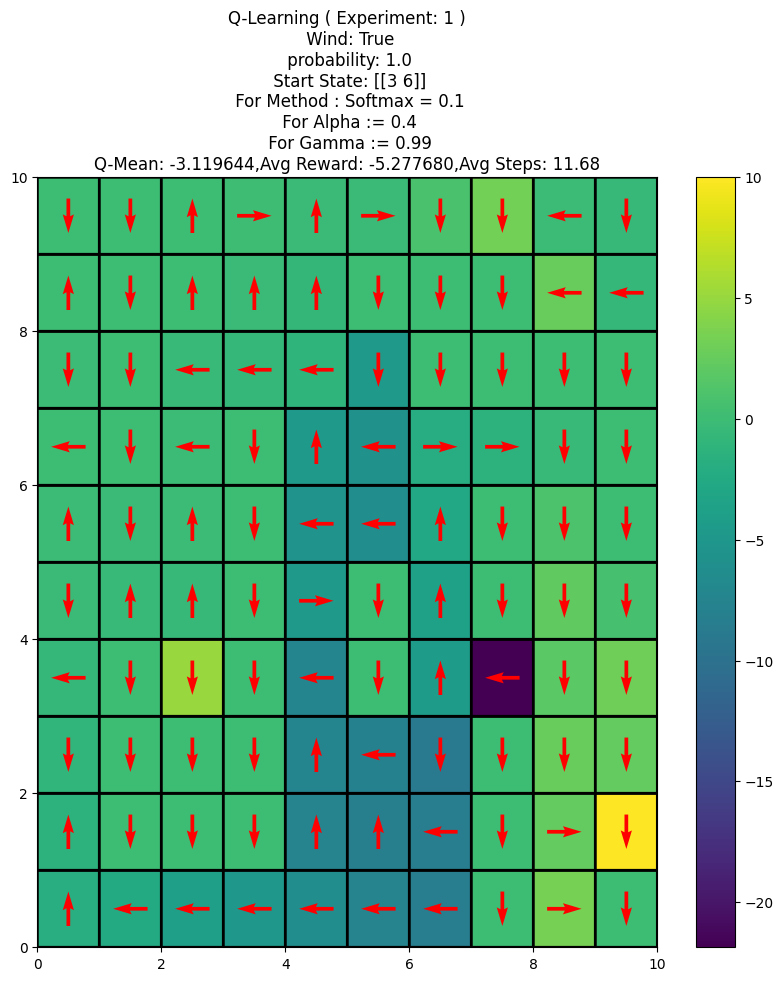

In [25]:
# Note:


f1=0 # choose Experiment number use 0-based index from above environments list

f2=0 # for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters

epsilon=0.1

# Assigning best hyperparameter values based on graph provided in report

if(f1==0): # f1 is Experiment number 0 based index so f1 ranges from 0 to 5
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.4
  gamma=0.99
elif(f1==1):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
elif(f1==2):
  choose_action=1
  f2=1
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==3):
  choose_action=1
  f2=0
  tau=0.1
  alpha=0.2
  gamma=0.99
elif(f1==4):
  choose_action=1
  f2=0
  tau=0.4
  alpha=0.2
  gamma=0.99
elif(f1==5):
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
else:
  choose_action=1
  f2=0
  tau=0.01
  alpha=0.1
  gamma=0.99
  epsilon=0.1


num_expts = 5
reward_avgs, steps_avgs = np.zeros(5000), np.zeros(5000)
Q1=np.zeros((10,10,4)) # for storing Q values

for i in range(num_expts):
    print("Experiment: %d"%(f1+1))
    Q = np.zeros((10, 10, 4))
    rg = np.random.RandomState(i)

    # TODO: run sarsa, store metrics
    if(f2==0): # f2 used for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters
      Q, rewards, steps,visits = sarsa(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)
    elif(f2==1):
      Q, rewards, steps,visits = qlearning(list(environments.values())[f1], Q, plot_heat=False, choose_action=choose_action, epsilon= epsilon,tau = tau, alpha=alpha , gamma=gamma, experiment_number= i + 1)

    # adding Q values,reward and steps returned by algorithm 5 times
    Q1 = Q1 + Q
    reward_avgs = reward_avgs + rewards
    steps_avgs = steps_avgs + steps

#averaging over 5 runs
reward_avgs = reward_avgs/num_expts
steps_avgs = steps_avgs/num_expts
Q1 = Q1/num_expts



if(f2==1):# f2 used for chosing sarsa or q-learning based on result got from both algorithm using hyperparameters
  message = f"Q-Learning ( Experiment: {f1+1} )\n"
else:
  message = f"SARSA ( Experiment: {f1+1} )\n"
message += f" Wind: {list(environments.values())[f1].wind}\n"
message += f" probability: {list(environments.values())[f1].p_good_trans}\n"
message += f" Start State: {list(environments.values())[f1].start_state}\n"
if choose_action == 0:
    message += f" For Method Epsilon Greedy = {epsilon}\n"
else:
    message += f" For Method : Softmax = {tau}\n"
message += f" For Alpha := {alpha}\n"
message += f" For Gamma := {gamma}\n"
message += "Q-Mean: %f,Avg Reward: %f,Avg Steps: %.2f"%(np.mean(Q1),np.mean(reward_avgs),np.mean(steps_avgs))

plot_Q(Q1,message)

In [23]:
environments

{'wind=True, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7df0>,
 'wind=True, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7160>,
 'wind=False, p_good_transition=1.0, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c7130>,
 'wind=False, p_good_transition=1.0, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c7190>,
 'wind=False, p_good_transition=0.7, start_state=[[3 6]]': <__main__.GridWorld at 0x7e89841c41c0>,
 'wind=False, p_good_transition=0.7, start_state=[[0 4]]': <__main__.GridWorld at 0x7e89841c52a0>}

# ROBOT MOVEMENT DEMO

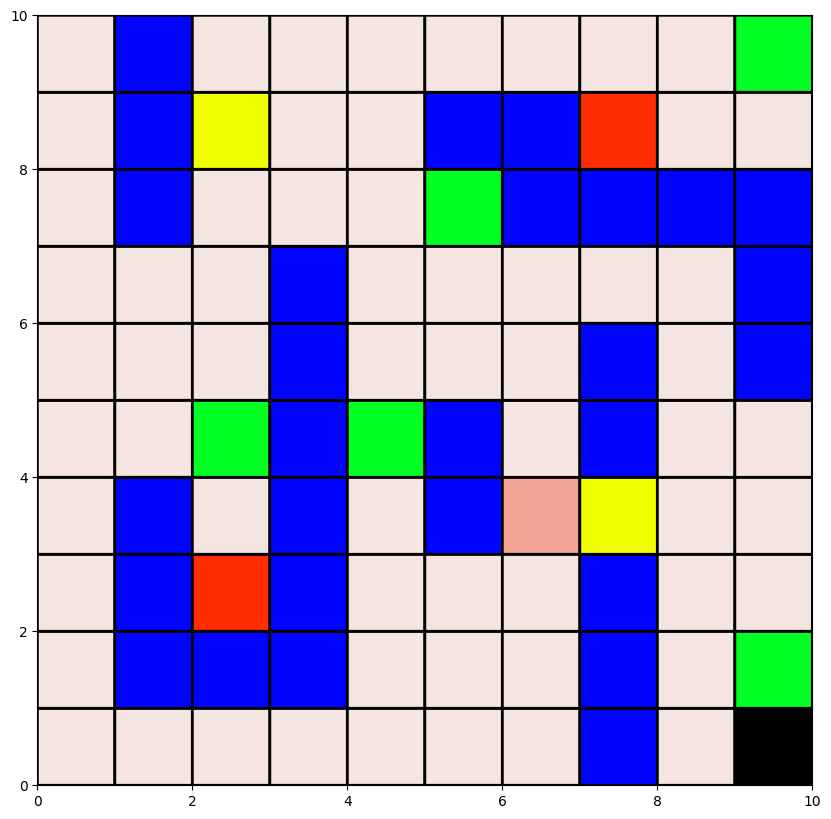

Steps: 10, Total Reward: -4


<ipython-input-28-cc206ba2421e>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


In [28]:
from time import sleep
import matplotlib.pyplot as plt

i=0 # Choose which environment you want to see from above 6 i value is from 0 to 5

env2=list(environments.values())[i]

state = env2.reset()
state_ = seq_to_col_row(state, num_cols)
done = False
steps = 0
tot_reward = 0

while not done:
    clear_output(wait=True)
    state, reward, done = env2.step(state,Q[state_[0][0]][state_[0][1]].argmax())
    state_=seq_to_col_row(state, num_cols)
    plt.figure(figsize=(10, 10))
    env.render(state_,ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))